<a href="https://www.kaggle.com/code/jorgeluiscruzquispe/fundo?scriptVersionId=189912929" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <center>Diseño de zona de vivencia rural</center>
---

In [1]:
!pip install -q geemap leafmap 

In [2]:
from shapely.geometry import Point, Polygon
import leafmap.foliumap as leafmap
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import geemap.colormaps as cmap
from bs4 import BeautifulSoup
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import urllib3
import os
import ee

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AcvDMrAcozdg-iecH86WYzBJg0oB1XSYCP91diayOSIjvIPk3Y5wRL9-BpE



Successfully saved authorization token.


## Cuenca hidrografica

In [4]:
Map = geemap.Map()

val_min = 2400

val_max = 2800

nombre_distrito = "CHANCAY"; nombre_provincia = "HUARAL"; nombre_departamento = "LIMA"

ubicacion = ee.Geometry.Point([-76.839656,-11.237495])

distrito = ee.FeatureCollection("users/jorgeluiscruzquispe7/distritos")\
                                                    .filter(ee.Filter.eq("DEPARTAMEN", nombre_departamento))\
                                                    .filter(ee.Filter.eq("PROVINCIA", nombre_provincia))\
                                                    .filter(ee.Filter.eq("DISTRITO", nombre_distrito))

punto = ee.Geometry.Point([-77.287445,-11.510304])

unidades_hidrograficas = ee.FeatureCollection("users/jorgeluiscruzquispe7/UnidadesHidrograficas")

unidad_hidrografica = ee.FeatureCollection("users/jorgeluiscruzquispe7/UnidadesHidrograficas")\
                                                        .filterBounds(distrito)

redes_hidrograficas = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_hidrografica_cenepred")\
                                                        .filterBounds(unidad_hidrografica)

red_vial_nacional = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_vial_nacional_dic18")\
                                                        .filterBounds(unidad_hidrografica)

red_vial_departamental = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_vial_departamental_dic18")\
                                                        .filterBounds(unidad_hidrografica)

red_vial_vecinal = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_vial_vecinal_dic18")\
                                                        .filterBounds(unidad_hidrografica)

centros_poblados = ee.FeatureCollection("users/jorgeluiscruzquispe7/Centros_poblados").filterBounds(unidad_hidrografica)

srtm = ee.Image("USGS/SRTMGL1_003").clip(unidad_hidrografica)

range_dem = srtm.updateMask(srtm.gte(val_min).And(srtm.lte(val_max)))

pendiente = ee.Terrain.slope(range_dem)

aspecto = ee.Terrain.aspect(range_dem)

# parametros de dem
range_dem_params = {
    "palette": cmap.palettes.jet, 
    "min": val_min, 
    "max": val_max
}

line_params = {
    'colorOpacity': 1,
    'pointSize': 3,
    'pointShape': 'circle',
    'lineType': 'dashed', 
    'fillColorOpacity': 0.66    
}

palette_line = list(cmap.palettes.gist_earth.n12)

cuenca = unidad_hidrografica.getInfo()["features"][0]["properties"]["NOMBRE"]

linas_contorno_rango = geemap.create_contours(range_dem, val_min, val_max, 30, region = unidad_hidrografica.geometry())

Map.centerObject(distrito, 10)

Map.add_basemap("HYBRID")

Map.addLayer(range_dem, {"palette":cmap.palettes.Spectral_r, "min": val_min, "max": val_max}, "range raster data")

Map.add_layer(pendiente, {'min': 0, 'max': 89.99, "palette": cmap.palettes.jet}, 'plano de pendiente')

Map.add_layer(aspecto, {'min': 0, 'max': 359.99, "palette": cmap.palettes.jet}, 'plano de aspecto')

Map.addLayer(linas_contorno_rango, {"palette": "black"}, "countor lineas", opacity = 0.35)

Map.addLayer(ee.Image().paint(unidades_hidrograficas, 0, 2), {"palette":"black"}, "Cuencas del Perú")

Map.addLayer(ee.Image().paint(redes_hidrograficas, 0, 2.5), {"palette":"blue"}, "Ríos del Perú")

Map.addLayer(ee.Image().paint(unidad_hidrografica, 0, 3), {"palette":"red"}, cuenca)

Map.addLayer(ee.Image().paint(distrito, 0, 3.5), {"palette":"#07fc03"}, "distrito")

Map.addLayer(centros_poblados, {"color":"black"}, "centros poblados")

Map.add_colorbar(range_dem_params, label = 'Elevación (metros)', background_color = "silver")

Map.add_text(f"Busqueda de zona ideal", 
             position = "bottomleft", 
             fontcolor = 'white',
             bg_color = "black", 
             bold = True)

Map.add_styled_vector(red_vial_departamental, 
                      column = "DEPARTAMEN", 
                      palette = palette_line, 
                      layer_name = "red vial departamental", 
                      **line_params, 
                      color = "#ff6f00",
                      width = 3, shown = False)

Map.add_styled_vector(red_vial_vecinal, 
                      column = "DEPARTAMEN", 
                      palette = palette_line, 
                      layer_name = "red vial vecinal", 
                      **line_params, 
                      color = "#ff00e6",
                      width = 2.5, shown = False)

Map.add_styled_vector(red_vial_nacional, 
                      column = "DEPARTAMEN", 
                      palette = palette_line, 
                      layer_name = "red vial nacional", 
                      **line_params, 
                      color = "#fff700",
                      width = 3.5, shown = False)


Map.add_legend(title = "Leyenda", 
               labels = [f'Departamento de {nombre_departamento.capitalize()}', 
                         f"Provincias de {nombre_departamento.capitalize()}", 
                         f"Distritos de {nombre_departamento.capitalize()}", 
                         "Red vial nacional", 
                         "Red vial departamental", 
                         "Red vial vecinal"], 
               colors = ['#f50905', 
                         "#199101", 
                         "#1403a8", 
                         "#fff700", 
                         "#ff6f00", 
                         "#ff00e6"], 
               position ='bottomright')

Map.addLayer(punto.buffer(70000), {"color": "red"}, "buffer distrito de chancay", opacity = 0.25)

Map.addLayer(ubicacion.buffer(500), {"color": "green"}, "zona de ubicacion")

# download_dir = os.path.normpath(os.getcwd())
# if not os.path.exists(download_dir):
#     os.makedirs(download_dir)
# html_file = os.path.join(download_dir, 'mapa_testing.html')
# Map.to_html(filename=html_file, title='My Map', width='100%', height='880px')

Map

In [5]:
ubicacion_gdf = geemap.ee_to_gdf(ee.Feature(ubicacion))

zona_diseno_gdf = gpd.GeoDataFrame(geometry = [Polygon([[-76.84053,-11.236243],[-76.841721,-11.23577],[-76.841871,-11.23618],
                                                        [-76.842354,-11.236001],[-76.842563,-11.236454],[-76.840884,-11.237011],[-76.84053,-11.236243]])])


m = leafmap.Map()

m.add_gdf(zona_diseno_gdf, layer_name="zona de diseño")

m.add_gdf(geemap.ee_to_gdf(unidad_hidrografica), "unidad hidrografica", info_mode = None, fill_colors = ["red"])

m.add_gdf(ubicacion_gdf, layer_name="zona de ubicación")

m.add_basemap("TERRAIN")

m.add_basemap("HYBRID")

m.set_center(ubicacion.getInfo()["coordinates"][0], ubicacion.getInfo()["coordinates"][1], zoom = 16)

m.to_html("bosquejo.html")

m

In [6]:
Map = geemap.Map()

fecha_inicial = "2022-01-01"

fecha_final = "2022-01-30"

zona_diseno = zona_diseno = ee.Geometry.Polygon(geemap.geopandas_to_ee(zona_diseno_gdf.set_crs(4326))\
                                                    .getInfo()["features"][0]["geometry"]["coordinates"])

punto = ee.Geometry.Point(zona_diseno.centroid().getInfo()["coordinates"])

unidades_hidrograficas = ee.FeatureCollection("users/jorgeluiscruzquispe7/UnidadesHidrograficas")

unidad_hidrografica = ee.FeatureCollection("users/jorgeluiscruzquispe7/UnidadesHidrograficas")\
                                                        .filterBounds(punto)

chirps_sum =  ee.ImageCollection(ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
                                                            .select(['precipitation'])\
                                                            .filterDate(fecha_inicial, fecha_final))\
                                                            .sum()\
                                                            .clip(unidad_hidrografica)

pp_max = (chirps_sum.reduceRegion(reducer = ee.Reducer.max(), 
                                  geometry = unidad_hidrografica, scale = 100)).getInfo()["precipitation"]
pp_min = (chirps_sum.reduceRegion(reducer = ee.Reducer.min(), 
                                  geometry = unidad_hidrografica, scale = 100)).getInfo()["precipitation"]

pp_params = {
    "palette": cmap.palettes.jet, 
    "min": pp_min, 
    "max": pp_max
}

Map.centerObject(unidad_hidrografica)

Map.addLayer(chirps_sum, pp_params, "pp rango", opacity = 0.35)

Map.addLayer(ee.Image().paint(unidad_hidrografica, 0, 3), {"palette":"red"}, cuenca)

Map.add_colorbar(pp_params, label = 'Precipitación (mm)', background_color = "silver")

Map.add_text(f"Precipitación areal mensual la cuenca de la zona de diseño", 
             position = "bottomleft", 
             fontcolor = 'white',
             bg_color = "black", 
             bold = True)

Map

## Elevación de la zona seleccionada

In [7]:
Map = geemap.Map()

unidad_hidrografica = ee.FeatureCollection("users/jorgeluiscruzquispe7/UnidadesHidrograficas").filterBounds(zona_diseno.centroid())

red_hidrografica = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_hidrografica_cenepred").filterBounds(unidad_hidrografica)

zona_estudio = zona_diseno.centroid().buffer(1500)

srtm_clip = ee.Image("USGS/SRTMGL1_003").clip(zona_estudio)

max_elevation = (srtm_clip.reduceRegion(reducer = ee.Reducer.max(), geometry = zona_estudio, scale = 100)).getInfo()["elevation"]

min_elevation = (srtm_clip.reduceRegion(reducer = ee.Reducer.min(), geometry = zona_estudio, scale = 100)).getInfo()["elevation"]

contours_lines = geemap.create_contours(srtm_clip, min_elevation, max_elevation, 10, region = zona_estudio)

cuenca = unidad_hidrografica.getInfo()["features"][0]["properties"]["NOMBRE"]

# parametros de dem
dem_params = {
    "palette": cmap.palettes.jet, 
    "min": min_elevation, 
    "max": max_elevation
}

Map.add_basemap("TERRAIN")

Map.centerObject(zona_diseno, 15)

Map.addLayer(ee.Image().paint(unidad_hidrografica, 0, 4), {'palette': 'green'}, 
             shown = True, 
             name = "unidad hidrografica")

Map.addLayer(ee.Image().paint(red_hidrografica, 0, 3), {'palette': 'blue'}, 
             shown = True, 
             name = "red hidrografica")

Map.addLayer(srtm_clip, dem_params, "dem", opacity = 0.35)

Map.addLayer(contours_lines, {"palette": "black"}, "countor lineas", opacity = 0.35)

Map.addLayer(ee.Image().paint(zona_diseno, 0, 2), {"palette": "orange"}, name = "zona a diseñar", shown = True)

Map.addLayer(zona_diseno.centroid(), {"color": "red"}, "centroide")

Map.addLayer(ee.Image().paint(zona_estudio, 0, 3.5), {"palette": "red"}, name = "zona de estudio", shown = True)

Map.add_colorbar(dem_params, label = 'Elevación (metros)', background_color = "silver")

Map.add_text(f"Mapa de elevación de la zona de estudio", 
             position = "bottomleft", 
             fontcolor = 'white',
             bg_color = "black", 
             bold = True)


Map.add_legend(title = "Leyenda", 
               labels = ['Zona de estudio', "Red hidrografica", "Area de diseño", cuenca], 
               colors = ['#f50905', "#0015ff", "#ffa200", "#00ff11"], 
               position ='bottomright')

Map

## Mapa politico

In [8]:
Map = geemap.Map()

departamento = ee.FeatureCollection("users/jorgeluiscruzquispe7/departamentos")\
                                                        .filterBounds(zona_diseno.centroid())

nombre_departamento = departamento.getInfo()["features"][0]["properties"]["DEPARTAMEN"]

provincias = ee.FeatureCollection("users/jorgeluiscruzquispe7/provincias")\
                                                        .filter(ee.Filter.eq("DEPARTAMEN", nombre_departamento))

distritos = ee.FeatureCollection("users/jorgeluiscruzquispe7/distritos")\
                                                        .filter(ee.Filter.eq("DEPARTAMEN", nombre_departamento))

red_vial_nacional = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_vial_nacional_dic18")\
                                                        .filter(ee.Filter.eq("DEPARTAMEN", nombre_departamento))

red_vial_departamental = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_vial_departamental_dic18")\
                                                        .filter(ee.Filter.eq("DEPARTAMEN", nombre_departamento))

red_vial_vecinal = ee.FeatureCollection("users/jorgeluiscruzquispe7/red_vial_vecinal_dic18")\
                                                        .filter(ee.Filter.eq("DEPARTAMEN", nombre_departamento))

linas_contorno_rango = geemap.create_contours(range_dem, val_min, val_max, 30, region = unidad_hidrografica.geometry())

Map.centerObject(zona_diseno, 15)

line_params = {
    'colorOpacity': 1,
    'pointSize': 3,
    'pointShape': 'circle',
    'lineType': 'dashed', 
    'fillColorOpacity': 0.66    
}

palette_line = list(cmap.palettes.gist_earth.n12)

Map.add_basemap("ROADMAP")

Map.addLayer(ee.Image().paint(distritos, 0, 3), {'palette': 'blue'}, name = "distritos", shown = True)

Map.addLayer(ee.Image().paint(provincias, 0, 4), {'palette': 'green'}, name = "provincias", shown = True)

Map.addLayer(ee.Image().paint(departamento, 0, 5), {'palette': 'red'}, name = "departamento", shown = True)

Map.addLayer(ee.Image().paint(zona_diseno.centroid(), 0, 2), {"color": "red"}, "punto 2")

Map.addLayer(srtm_clip, dem_params, "dem", opacity = 0.35)

Map.addLayer(contours_lines, {"palette": "black"}, "countor lineas", opacity = 0.35)

Map.addLayer(ee.Image().paint(zona_estudio, 0, 3.5), {"palette": "red"}, name = "zona de estudio", shown = True)

Map.add_styled_vector(red_vial_departamental, 
                      column = "DEPARTAMEN", 
                      palette = palette_line, 
                      layer_name = "red vial departamental", 
                      **line_params, 
                      color = "#ff6f00",
                      width = 3)

Map.add_styled_vector(red_vial_vecinal, 
                      column = "DEPARTAMEN", 
                      palette = palette_line, 
                      layer_name = "red vial vecinal", 
                      **line_params, 
                      color = "#ff00e6",
                      width = 2.5)

Map.add_styled_vector(red_vial_nacional, 
                      column = "DEPARTAMEN", 
                      palette = palette_line, 
                      layer_name = "red vial nacional", 
                      **line_params, 
                      color = "#fff700",
                      width = 3.5)

Map.add_text(f"Mapa politico de la zona de estudio", 
             position = "bottomleft", 
             fontcolor = 'white',
             bg_color = "black", 
             bold = True)

Map.add_legend(title = "Leyenda", 
               labels = [f'Departamento de {nombre_departamento.capitalize()}', 
                         f"Provincias de {nombre_departamento.capitalize()}", 
                         f"Distritos de {nombre_departamento.capitalize()}", 
                         "Red vial nacional", 
                         "Red vial departamental", 
                         "Red vial vecinal"], 
               colors = ['#f50905', 
                         "#199101", 
                         "#1403a8", 
                         "#fff700", 
                         "#ff6f00", 
                         "#ff00e6"], 
               position ='bottomright')

Map.addLayer(ee.Image().paint(zona_diseno, 0, 2), {"palette": "orange"}, name = "zona a diseñar", shown = True)

Map.addLayer(zona_diseno.centroid(), {"color": "red"}, "centroide")

Map

## Indices espectrales

In [9]:
Map = geemap.Map()


landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
                                .filterDate('2022-01-01', '2022-12-31')\
                                .select(['B1', 'B2', 'B3', 'B4', 'B5','B6', 'B7'])\
                                .filterMetadata('CLOUD_COVER_LAND', 'less_than', 10)

Map.add_basemap("HYBRID")

Map.centerObject(zona_estudio, 15)


def norm_img(datasetCorte, b1, b2):
    return datasetCorte.normalizedDifference([b1, b2])

datasetVis = ee.Image(landsat.median())

datasetCorte = datasetVis.clip(zona_estudio)

ndvi1 = norm_img(datasetCorte, "B5", "B4")

ndwi1 = norm_img(datasetCorte, "B3", "B5")

min_ndvi = list(ndvi1.reduceRegion(ee.Reducer.min(), 
                                   geometry = zona_estudio, 
                                   scale = 30).getInfo().values())[0]

max_ndvi = list(ndvi1.reduceRegion(ee.Reducer.max(), 
                                   geometry = zona_estudio, 
                                   scale = 30).getInfo().values())[0]

min_ndwi = list(ndwi1.reduceRegion(ee.Reducer.min(), 
                                   geometry = zona_estudio, 
                                   scale = 30).getInfo().values())[0]

max_ndwi = list(ndwi1.reduceRegion(ee.Reducer.max(), 
                                   geometry = zona_estudio, 
                                   scale = 30).getInfo().values())[0]

ndviParams = {'palette': cmap.palettes.ndvi, "max": max_ndvi, "min": min_ndvi}

ndwiParams = {'palette': cmap.palettes.ndwi, "max": max_ndwi, "min": min_ndwi}

# coleccion visibildad - vist parameter
TrueColor432 = {
    'bands': ['B6', 'B5', 'B2'],
    'min' : 0.0,
    'max' : 0.4
}

# visualizar imagen

Map.addLayer(ndwi1, ndwiParams, 'ndwi cuenca')

Map.addLayer(ndvi1, ndviParams, 'ndvi cuenca')


Map.addLayer(datasetCorte, TrueColor432, 'image cuenca', shown = False)

Map.addLayer(ee.Image().paint(zona_estudio, 0, 3.5), {"palette": "red"}, name = "zona de estudio", shown = True)

Map.add_colorbar(ndviParams, label = 'NDVI', background_color = "silver")

Map.add_colorbar(ndwiParams, label = 'NDWI', background_color = "silver")

Map.add_text(f"Mapa de Indices Espectrales", 
             position = "bottomleft", 
             fontcolor = 'white',
             bg_color = "black", 
             bold = True)

Map.add_legend(title = "Leyenda", 
               labels = ['Zona de estudio'], 
               colors = ["#f50905"],
               position ='bottomright')

Map


## Caracterisicas del area de diseño

In [10]:
print(f"Area: {(zona_diseno.area().getInfo()/10000):.2f} hectareas")
print(f"Perimetro: {(zona_diseno.perimeter().getInfo()):.2f} metros")
print(f"Departamento: " + distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["DEPARTAMEN"].capitalize())
print(f"Provincia: " + distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["PROVINCIA"].capitalize())
print(f"Distrito: " + distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["DISTRITO"].capitalize())

Area: 1.65 hectareas
Perimetro: 586.56 metros
Departamento: Lima
Provincia: Huaral
Distrito: Lampian


## Precipitación en el area de diseño

In [11]:
def create_reduce_region_function(geometry,reducer = ee.Reducer.mean(),scale = 1000,
                                  crs = 'EPSG:4326',bestEffort = True,
                                  maxPixels = 1e13,tileScale = 4):
    def reduce_region_function(img):
        stat = img.reduceRegion(
            reducer = reducer,
            geometry = geometry,
            scale = scale,
            crs = crs,
            bestEffort = bestEffort,
            maxPixels = maxPixels,
            tileScale = tileScale)
        return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
    return reduce_region_function

def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
        reducer = ee.Reducer.toList().repeat(prop_names.size()),
        selectors = prop_names).get('list')
    return ee.Dictionary.fromLists(prop_names, prop_lists)

In [12]:
fecha_inicial = '2010-01-01'; fecha_final = '2023-12-31'

chirps =  ee.ImageCollection(ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
                             .select(['precipitation'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = zona_diseno.centroid(), 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

chirps_red = (ee.FeatureCollection(chirps.map(puntos_red)).filter(ee.Filter.notNull(chirps.first().bandNames())))

puntos_chirps = fc_to_dict(chirps_red).getInfo()

puntos_chirps = pd.DataFrame(puntos_chirps)

puntos_chirps['Fecha'] = pd.to_datetime(puntos_chirps["system:index"], format='%Y%m%d')

puntos_chirps.set_index('Fecha', inplace=True)
    
puntos_chirps = puntos_chirps.drop(columns = ["millis", "system:index"])
    
puntos_chirps = puntos_chirps.resample("ME").sum()

puntos_chirps.T

Fecha,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,...,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31
precipitation,59.213932,42.61113,62.525355,16.293153,0.0,0.0,0.0,0.0,8.330772,21.455027,...,92.829083,30.694272,10.657711,0.0,0.0,0.0,10.441618,24.878549,34.967651,43.142166


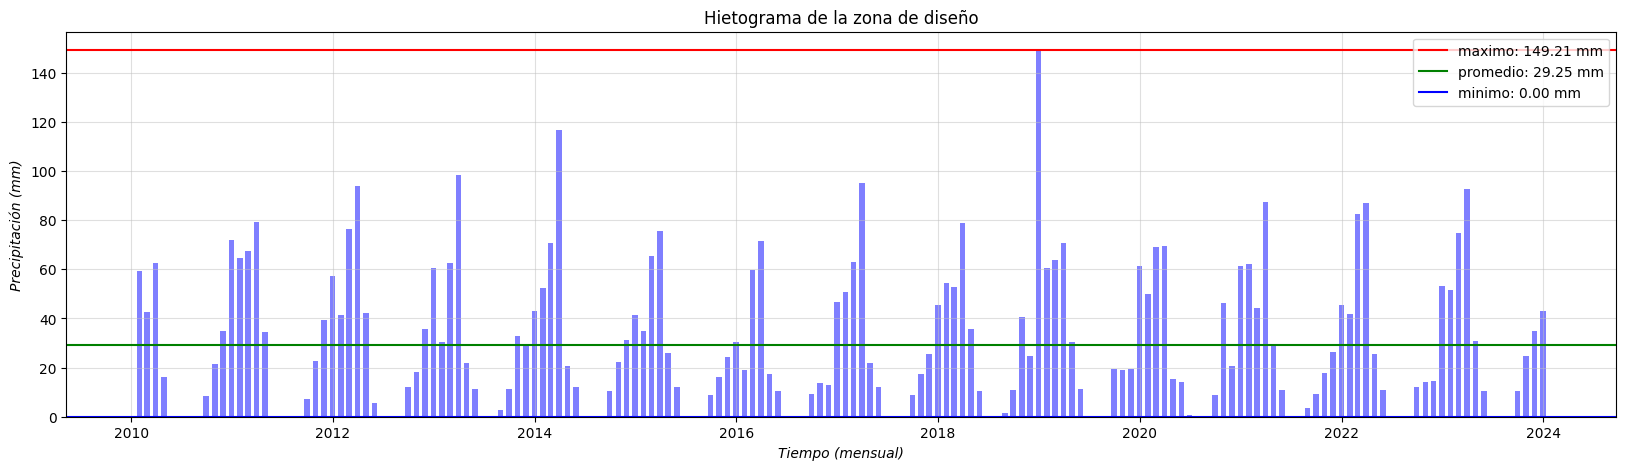

In [13]:
plt.figure(figsize=(20, 5))
plt.title("Hietograma de la zona de diseño")
plt.ylabel("Precipitación (mm)", style = "italic")
plt.xlabel("Tiempo (mensual)", style = "italic")
plt.axhline(y = puntos_chirps["precipitation"].max(), color = "red")
plt.axhline(y = puntos_chirps["precipitation"].mean(), color = "green")
plt.axhline(y = puntos_chirps["precipitation"].min(), color = "blue")
plt.grid(True, c = "silver", alpha = 0.5)
plt.legend(labels = [f"maximo: {(puntos_chirps['precipitation'].max()):.2f} mm",
                    f"promedio: {(puntos_chirps['precipitation'].mean()):.2f} mm",
                    f"minimo: {(puntos_chirps['precipitation'].min()):.2f} mm"],
           loc = "upper right")

plt.bar(puntos_chirps.index, puntos_chirps["precipitation"], color = "blue", alpha = 0.5, width = 20, label = "data")

plt.show()

## Humedad en el area de diseño

In [14]:
fecha_inicial = '2010-01-01'; fecha_final = '2023-12-31'

humedad_max =  ee.ImageCollection(ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001")\
                             .select(['Qair_f_tavg'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = zona_diseno.centroid(), 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

humedad_max_red = (ee.FeatureCollection(humedad_max.map(puntos_red)).filter(ee.Filter.notNull(humedad_max.first().bandNames())))

puntos_humedad_max = fc_to_dict(humedad_max_red).getInfo()

puntos_humedad_max = pd.DataFrame(puntos_humedad_max)

puntos_humedad_max['Fecha'] = pd.to_datetime(puntos_humedad_max["system:index"], format='%Y%m')

puntos_humedad_max.set_index('Fecha', inplace=True)
    
puntos_humedad_max = puntos_humedad_max.drop(columns = ["millis", "system:index"])
    
puntos_humedad_max.T

Fecha,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,...,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
Qair_f_tavg,0.009782,0.010405,0.010216,0.009451,0.008368,0.007416,0.006461,0.005979,0.006799,0.007199,...,0.010604,0.010829,0.008934,0.007546,0.008017,0.008069,0.008105,0.009626,0.00888,0.009922


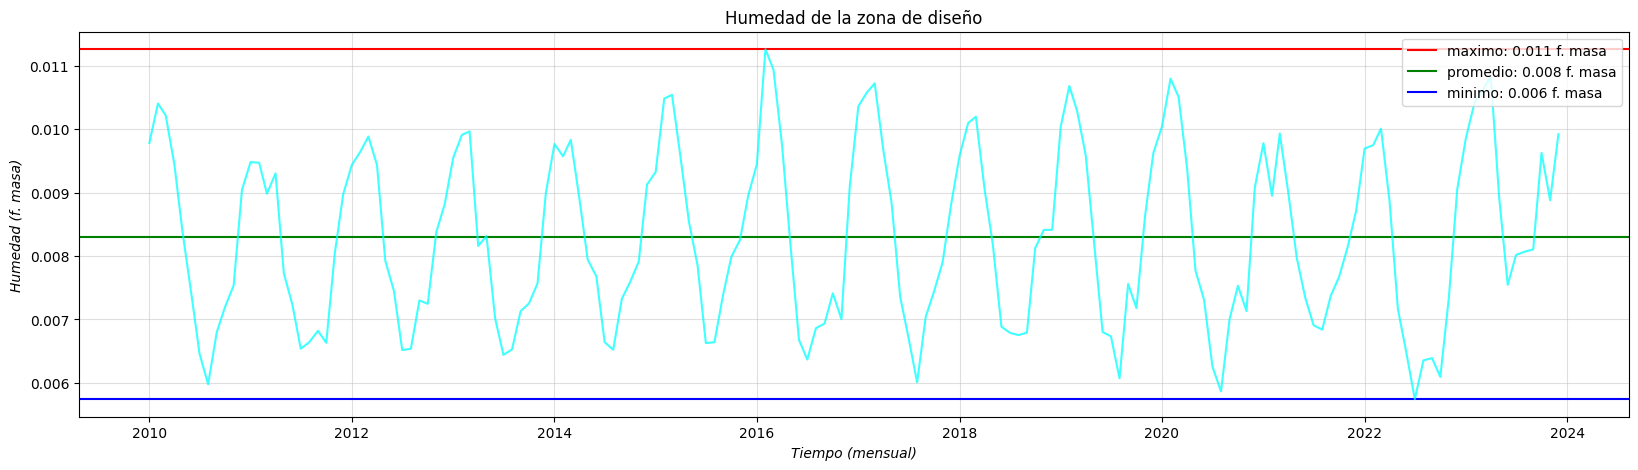

In [15]:
plt.figure(figsize=(20, 5))
plt.title("Humedad de la zona de diseño")
plt.ylabel("Humedad (f. masa)", style = "italic")
plt.xlabel("Tiempo (mensual)", style = "italic")
plt.axhline(y = puntos_humedad_max["Qair_f_tavg"].max(), color = "red", lw = 1.5)
plt.axhline(y = puntos_humedad_max["Qair_f_tavg"].mean(), color = "green", lw = 1.5)
plt.axhline(y = puntos_humedad_max["Qair_f_tavg"].min(), color = "blue", lw = 1.5)
plt.grid(True, c = "silver", alpha = 0.5)
plt.legend(labels = [f"maximo: {(puntos_humedad_max['Qair_f_tavg'].max()):.3f} f. masa",
                    f"promedio: {(puntos_humedad_max['Qair_f_tavg'].mean()):.3f} f. masa",
                    f"minimo: {(puntos_humedad_max['Qair_f_tavg'].min()):.3f} f. masa"],
           loc = "upper right")
plt.plot(puntos_humedad_max.index, puntos_humedad_max["Qair_f_tavg"], 
        color = "cyan", alpha = 0.75, label = "data")
plt.show()

## Temperatura en el area de diseño

In [17]:
fecha_inicial = '2019-01-01'; fecha_final = '2023-12-31'

temperatura =  ee.ImageCollection(ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H")\
                             .select(['Tair_f_inst'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = zona_diseno.centroid(), 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

temp_red = (ee.FeatureCollection(temperatura.map(puntos_red)).filter(ee.Filter.notNull(temperatura.first().bandNames())))

puntos_temp = fc_to_dict(temp_red).getInfo()

puntos_temp = pd.DataFrame(puntos_temp)

puntos_temp['Fecha'] = pd.to_datetime(puntos_temp["system:index"].str[1:], format = '%Y%m%d_%H%M')

puntos_temp.set_index('Fecha', inplace = True)
    
puntos_temp = puntos_temp.drop(columns = ["millis", "system:index"])
    
puntos_temp.T

Fecha,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2023-12-29 18:00:00,2023-12-29 21:00:00,2023-12-30 00:00:00,2023-12-30 03:00:00,2023-12-30 06:00:00,2023-12-30 09:00:00,2023-12-30 12:00:00,2023-12-30 15:00:00,2023-12-30 18:00:00,2023-12-30 21:00:00
Tair_f_inst,287.549835,288.084839,287.789856,286.966919,288.686951,291.888092,291.998108,290.620026,287.849365,287.934326,...,289.720398,288.937866,286.982819,286.939575,287.197144,286.655182,287.531799,290.28009,290.28183,288.63681


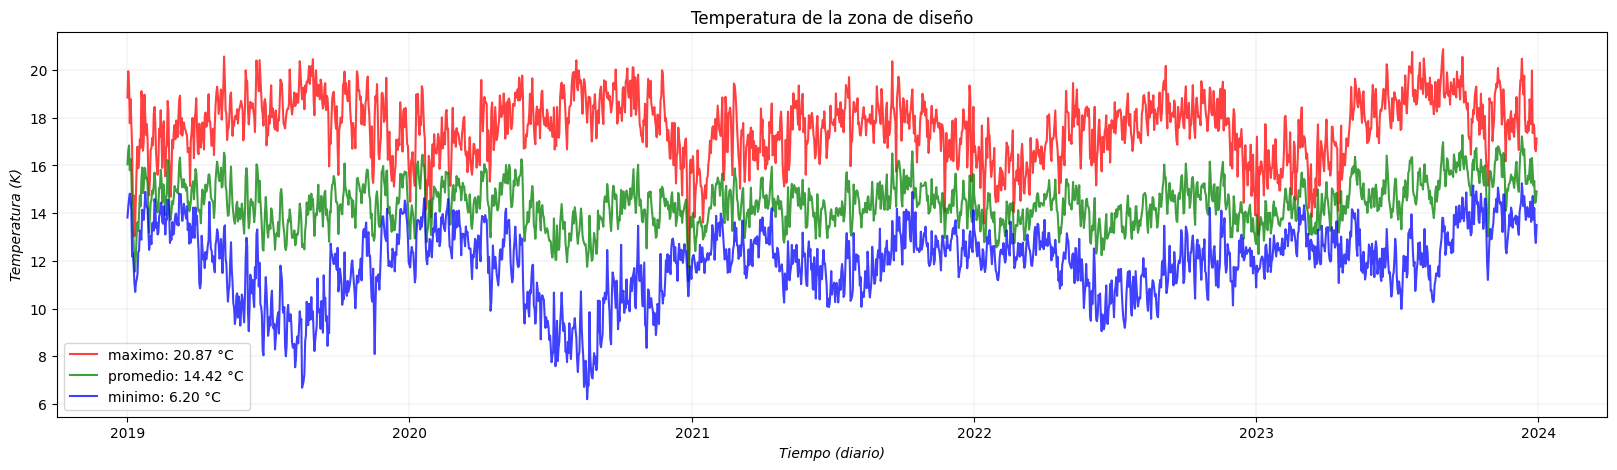

In [18]:
puntos_temp.index.freq = "3H"
puntos_temp["tem_max"] = puntos_temp["Tair_f_inst"].resample('D').max()
puntos_temp["tem_min"] = puntos_temp["Tair_f_inst"].resample('D').min()
puntos_temp["tem_mean"] = puntos_temp["Tair_f_inst"].resample('D').mean()

temp_df = pd.DataFrame({
    "tem_max": puntos_temp["Tair_f_inst"].resample('D').max(),
    "tem_min": puntos_temp["Tair_f_inst"].resample('D').min(),
    "tem_mean": puntos_temp["Tair_f_inst"].resample('D').mean()
})

temp_df = temp_df - 273.15 # pasando a celcius

plt.figure(figsize = (20, 5))
plt.plot(temp_df.index, temp_df.tem_max, c = "red", 
         label = f"maximo: {(temp_df.tem_max.max()):.2f} °C", alpha = 0.75, lw = 1.5)
plt.plot(temp_df.index, temp_df.tem_mean, c = "green", 
         label = f"promedio: {(temp_df.tem_mean.mean()):.2f} °C", alpha = 0.75, lw = 1.5)
plt.plot(temp_df.index, temp_df.tem_min, c = "blue", 
         label = f"minimo: {(temp_df.tem_min.min()):.2f} °C", alpha = 0.75, lw = 1.5)
plt.title("Temperatura de la zona de diseño")
plt.xlabel("Tiempo (diario)", style = "italic")
plt.ylabel("Temperatura (K)", style = "italic")
plt.grid(True, c = "silver", lw = 0.2)
plt.legend()
plt.show()

## Radiación en el area de diseño

In [19]:
ECMWF  =  ee.ImageCollection(ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")\
                             .select(['surface_net_solar_radiation_sum'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = zona_diseno.centroid(), 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

ECMWF_red = (ee.FeatureCollection(ECMWF.map(puntos_red)).filter(ee.Filter.notNull(ECMWF.first().bandNames())))

puntos_ECMWF = fc_to_dict(ECMWF_red).getInfo()

puntos_ECMWF = pd.DataFrame(puntos_ECMWF)

puntos_ECMWF['Fecha'] = pd.to_datetime(puntos_ECMWF["system:index"], format = '%Y%m%d')

puntos_ECMWF.set_index('Fecha', inplace = True)
    
puntos_ECMWF = puntos_ECMWF.drop(columns = ["millis", "system:index"])

puntos_ECMWF = puntos_ECMWF/1000

puntos_ECMWF.T

Fecha,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2023-12-21,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30
surface_net_solar_radiation_sum,20296.18,23412.95,22995.146,19927.744,21080.372,18663.926,21569.502,13061.476,11784.996,13551.42,...,16114.664,18799.926,21525.086,21588.198,14519.116,20850.772,15540.492,14366.616,15712.114,16025.354


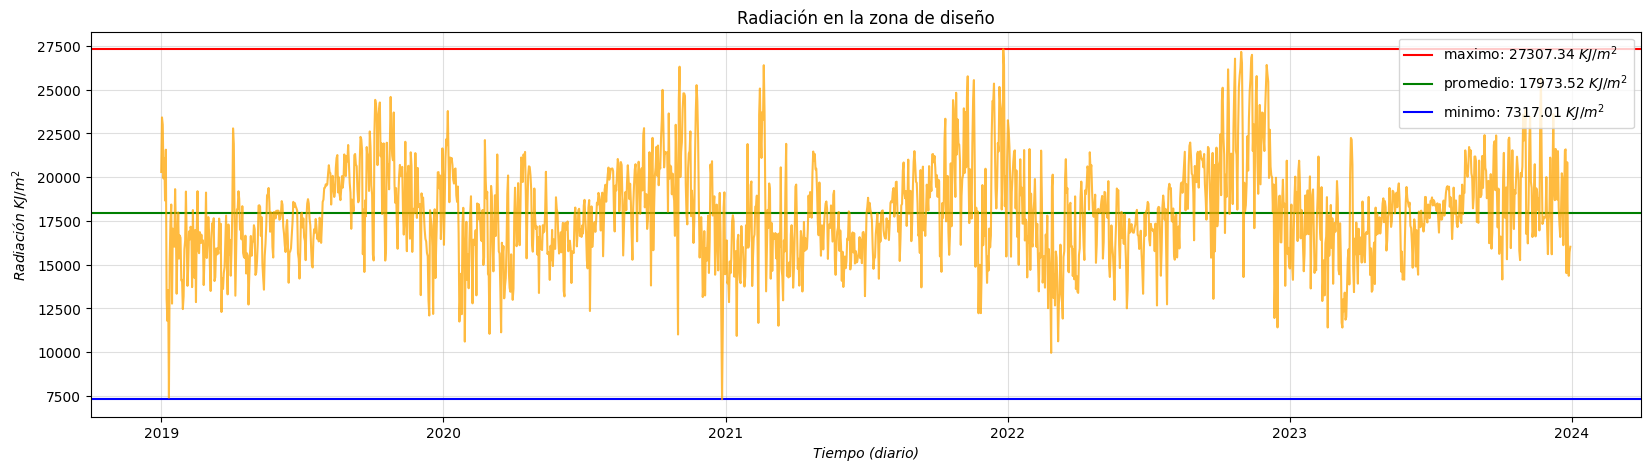

In [20]:
plt.figure(figsize=(20, 5))
plt.title("Radiación en la zona de diseño")
plt.ylabel("Radiación $KJ/m^2$", style = "italic")
plt.xlabel("Tiempo (diario)", style = "italic")
plt.axhline(y = puntos_ECMWF["surface_net_solar_radiation_sum"].max(), color = "red", lw = 1.5)
plt.axhline(y = puntos_ECMWF["surface_net_solar_radiation_sum"].mean(), color = "green", lw = 1.5)
plt.axhline(y = puntos_ECMWF["surface_net_solar_radiation_sum"].min(), color = "blue", lw = 1.5)
plt.grid(True, c = "silver", alpha = 0.5)
plt.legend(labels = [f"maximo: {(puntos_ECMWF['surface_net_solar_radiation_sum'].max()):.2f} $KJ/m^2$",
                    f"promedio: {(puntos_ECMWF['surface_net_solar_radiation_sum'].mean()):.2f} $KJ/m^2$",
                    f"minimo: {(puntos_ECMWF['surface_net_solar_radiation_sum'].min()):.2f} $KJ/m^2$"],
           loc = "upper right")
plt.plot(puntos_ECMWF.index, puntos_ECMWF["surface_net_solar_radiation_sum"], 
        color = "orange", alpha = 0.75,label = "data")
plt.show()

## velocidad de viento

In [21]:
fecha_inicial = '2010-01-01'; fecha_final = '2023-12-31'

wind =  ee.ImageCollection(ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001")\
                             .select(['Wind_f_tavg'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = zona_diseno.centroid(), 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

wind_red = (ee.FeatureCollection(wind.map(puntos_red)).filter(ee.Filter.notNull(wind.first().bandNames())))

puntos_wind = fc_to_dict(wind_red).getInfo()

puntos_wind = pd.DataFrame(puntos_wind)

puntos_wind['Fecha'] = pd.to_datetime(puntos_wind["system:index"], format='%Y%m')

puntos_wind.set_index('Fecha', inplace=True)
    
puntos_wind = puntos_wind.drop(columns = ["millis", "system:index"])
    
puntos_wind.T

Fecha,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,...,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
Wind_f_tavg,3.001852,3.020825,3.044755,3.106903,3.172224,3.341339,3.567083,3.912383,3.528953,3.456474,...,2.648026,2.776026,3.190965,3.622266,3.368414,3.398767,3.492121,2.955192,3.105111,3.085464


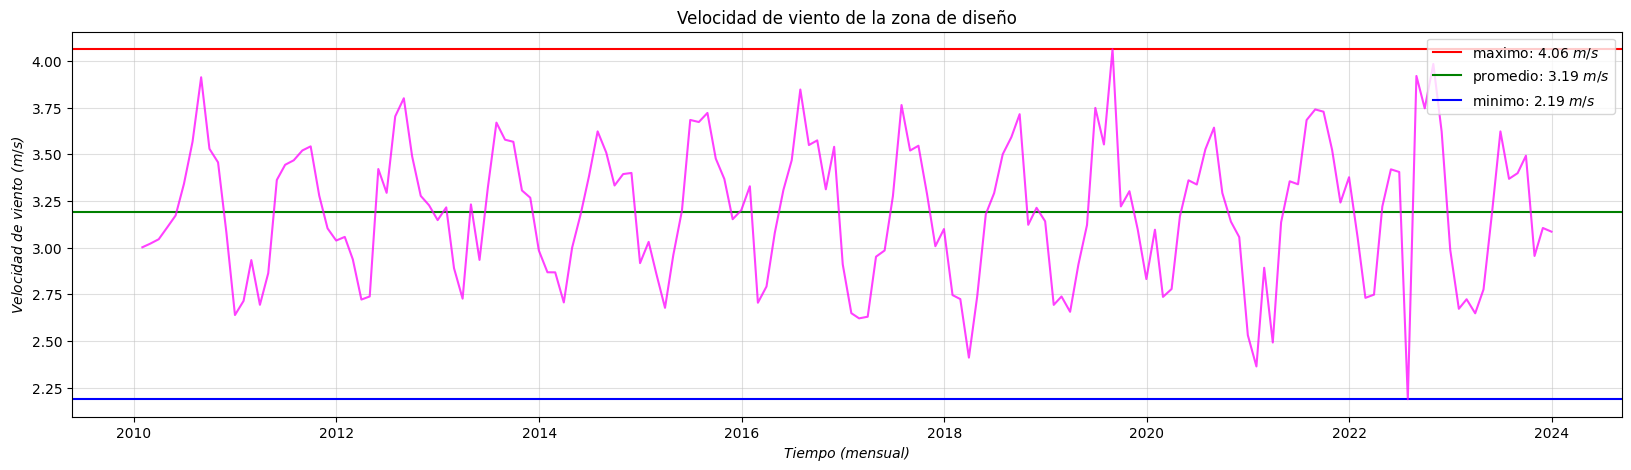

In [22]:
plt.figure(figsize=(20, 5))
plt.title("Velocidad de viento de la zona de diseño")
plt.ylabel("Velocidad de viento ($m/s$)", style = "italic")
plt.xlabel("Tiempo (mensual)", style = "italic")
plt.axhline(y = puntos_wind["Wind_f_tavg"].max(), color = "red", lw = 1.5)
plt.axhline(y = puntos_wind["Wind_f_tavg"].mean(), color = "green", lw = 1.5)
plt.axhline(y = puntos_wind["Wind_f_tavg"].min(), color = "blue", lw = 1.5)

plt.grid(True, c = "silver", alpha = 0.5)
plt.legend(labels = [f"maximo: {(puntos_wind['Wind_f_tavg'].max()):.2f} $m/s$",
                    f"promedio: {(puntos_wind['Wind_f_tavg'].mean()):.2f} $m/s$",
                    f"minimo: {(puntos_wind['Wind_f_tavg'].min()):.2f} $m/s$"],
           loc = "upper right")
plt.plot(puntos_chirps.index, puntos_wind["Wind_f_tavg"], color = "magenta", alpha = 0.75, label = "data")
plt.show()

## presión

In [23]:
fecha_inicial = '2010-01-01'; fecha_final = '2023-12-31'

pressure =  ee.ImageCollection(ee.ImageCollection("ECMWF/ERA5/DAILY")\
                             .select(['surface_pressure'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = zona_diseno.centroid(), 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

pressure_red = (ee.FeatureCollection(pressure.map(puntos_red)).filter(ee.Filter.notNull(pressure.first().bandNames())))

puntos_pressure = fc_to_dict(pressure_red).getInfo()

puntos_pressure = pd.DataFrame(puntos_pressure)

puntos_pressure['Fecha'] = pd.to_datetime(puntos_pressure["system:index"], format='%Y%m%d')

puntos_pressure.set_index('Fecha', inplace=True)
    
puntos_pressure = puntos_pressure.drop(columns = ["millis", "system:index"])
    
puntos_pressure = puntos_pressure/1000

puntos_pressure.T

Fecha,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09
surface_pressure,79.349523,79.212648,79.174578,79.185656,79.373273,79.364695,79.300406,79.257469,79.356492,79.336602,...,79.465227,79.414516,79.362555,79.406922,79.468195,79.489102,79.520062,79.528539,79.489875,79.454344


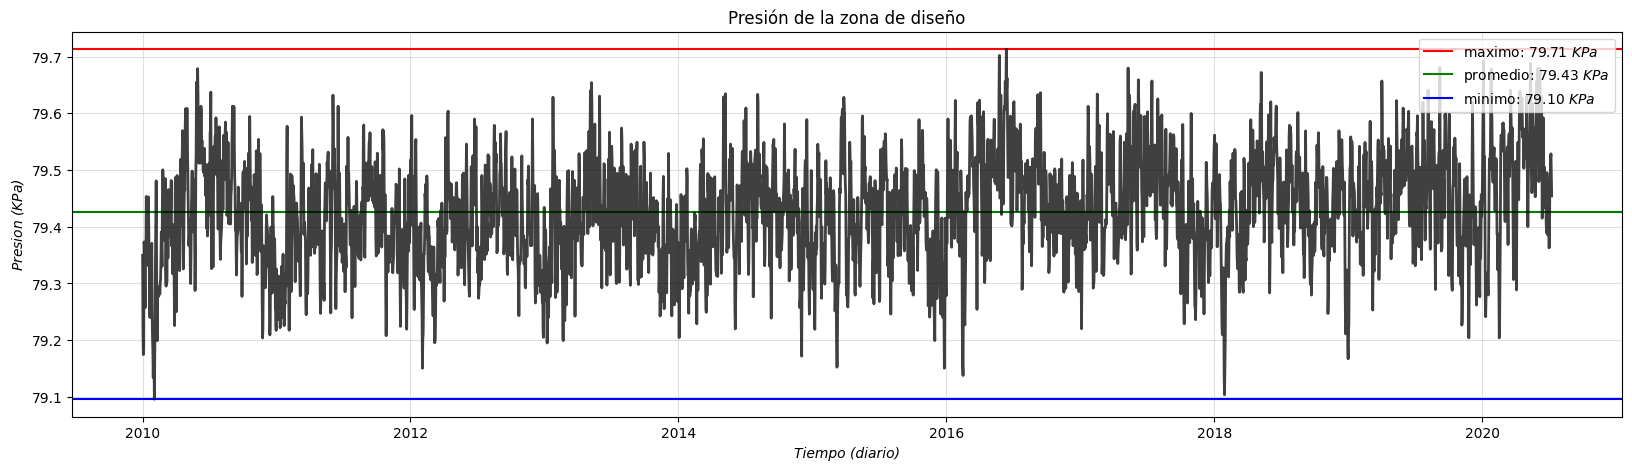

In [24]:
plt.figure(figsize=(20, 5))
plt.title("Presión de la zona de diseño")
plt.ylabel("Presion ($KPa$)", style = "italic")
plt.xlabel("Tiempo (diario)", style = "italic")
plt.axhline(y = puntos_pressure["surface_pressure"].max(), color = "red", lw = 1.5)
plt.axhline(y = puntos_pressure["surface_pressure"].mean(), color = "green", lw = 1.5)
plt.axhline(y = puntos_pressure["surface_pressure"].min(), color = "blue", lw = 1.5)

plt.grid(True, c = "silver", alpha = 0.5)
plt.legend(labels = [f"maximo: {(puntos_pressure['surface_pressure'].max()):.2f} $KPa$",
                    f"promedio: {(puntos_pressure['surface_pressure'].mean()):.2f} $KPa$",
                    f"minimo: {(puntos_pressure['surface_pressure'].min()):.2f} $KPa$"],
           loc = "upper right")
plt.plot(puntos_pressure.index, puntos_pressure["surface_pressure"], color = "black", alpha = 0.75, lw = 2, label = "data")
plt.show()

## Información del departamento (2007-2022)

In [25]:
def descarga_datos_inei(url, numero_hoja = 0):
    '''
    Sirve para descarga y convertir un excel de la inei en formato excel (solo coincidera la primera hoja por defecto)
        Args:
        url: Es el url que tienes que copiar de inei
    '''
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    nombre = os.path.basename(url)
    response = requests.get(url, verify = False)
    if response.status_code == 200:
        with open(nombre, 'wb') as f:
            f.write(response.content)
    else:
        print('Error de descarga', response.status_code)
    df = pd.read_excel(nombre, skiprows = 5, index_col = 0, header = 1, skipfooter = 6, sheet_name = numero_hoja)
    df = (df.iloc[1:,:]).transpose()
    df = df.drop(columns = ["Callao", "Lima Provincias", "Lima Metropolitana"], axis = 1)
    df["Año"] = pd.to_datetime(np.arange(df.index[0], df.index[0] + len(df)), format = "%Y")
    df = df.reset_index().drop(columns = ["index"]).set_index("Año")
    return df

In [ ]:
# descarga del pbi segun la actividad del departamento
datos_elec_agu_gas = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act05_12.xlsx")
construccion = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act06_13.xlsx")
alojamiento = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act09_12.xlsx")
pesca = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act02_16.xlsx")
aprocecuaria = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act01_14.xlsx")
minerales = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act03_14.xlsx")
comercio = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act07_12.xlsx")
telecomunicaciones = descarga_datos_inei("https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_act10_14.xlsx")

In [ ]:
plt.figure(figsize = (20, 5))
plt.title(f"PBI de electricidad agua y desague del departamento de {nombre_departamento.capitalize()}")
plt.bar(datos_elec_agu_gas.index, datos_elec_agu_gas[nombre_departamento.capitalize()], width = 100)
plt.ylabel("Millones de soles")
plt.xlabel("Tiempo (años)")
plt.grid(True, c = "black", lw = 0.5, alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.title(f"PBI de construcción del departamento {nombre_departamento.capitalize()}")
plt.bar(construccion.index, construccion[nombre_departamento.capitalize()], width = 100, color = "orange", zorder = 1)
plt.ylabel("Millones de soles")
plt.xlabel("Tiempo (años)")
plt.grid(True, c = "black", lw = 0.5, alpha = 0.5, zorder = 0)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.title(f"PBI de la pesca y acuicultura del departamento {nombre_departamento.capitalize()}")
plt.bar(pesca.index, pesca[nombre_departamento.capitalize()], width = 100, color = "green", zorder = 1)
plt.ylabel("Millones de soles")
plt.xlabel("Tiempo (años)")
plt.grid(True, c = "black", lw = 0.5, alpha = 0.5, zorder = 0)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.title(f"PBI de agricultura, ganadería, caza y silvicultura del departamento {nombre_departamento.capitalize()}")
plt.bar(aprocecuaria.index, aprocecuaria[nombre_departamento.capitalize()], width = 100, color = "cyan", zorder = 1)
plt.ylabel("Millones de soles")
plt.xlabel("Tiempo (años)")
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5, zorder = 0)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.title(f"PBI de la extracción de minerales del departamento {nombre_departamento.capitalize()}")
plt.bar(minerales.index, minerales[nombre_departamento.capitalize()], width = 100, color = "brown", zorder = 1)
plt.ylabel("Millones de soles")
plt.xlabel("Tiempo (años)")
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5, zorder = 0)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.title(f"PBI de Comercio del departamento {nombre_departamento.capitalize()}")
plt.bar(comercio.index, comercio[nombre_departamento.capitalize()], width = 100, color = "purple", zorder = 1)
plt.ylabel("Millones de soles")
plt.xlabel("Tiempo (años)")
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5, zorder = 0)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.title(f"PBI de Telecomunicaciones del departameto de {nombre_departamento.capitalize()}")
plt.bar(telecomunicaciones.index, telecomunicaciones[nombre_departamento.capitalize()], width = 100, color = "yellow", zorder = 1)
plt.ylabel("Millones de soles")
plt.xlabel("Tiempo (años)")
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5, zorder = 0)
plt.legend()
plt.show()

In [ ]:
def datos_abiertos_csv(url):
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    nombre = os.path.basename(url)
    response = requests.get(url, verify = False)
    if response.status_code == 200:
        with open(nombre, 'wb') as f:
            f.write(response.content)
    df = pd.read_csv(nombre, index_col = 0)
    return df

In [ ]:
poblacion = pd.read_csv("/kaggle/input/poblacion-inei/TB_POBLACION_INEI.csv", sep = ";")
poblacion_departamento = poblacion[poblacion["Departamento"] == nombre_departamento]
poblacion_prov = poblacion_departamento.groupby(["Provincia"]).sum()
poblacion_dist = poblacion_departamento.groupby(["Distrito"]).sum()
poblacion_distrital = poblacion_departamento[
    poblacion_departamento["Provincia"] == distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["PROVINCIA"]
]
poblacion_dist = poblacion_distrital.groupby(["Distrito"]).sum()
poblacion_genero = poblacion_distrital[
    poblacion_distrital["Distrito"] == distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["DISTRITO"]
]
poblacion_gen_dis = poblacion_genero.groupby(["Sexo"]).sum()
poblacion_edad = poblacion_genero.groupby(["Edad_Anio"]).sum()

In [ ]:
plt.figure(figsize=(20, 5))
plt.title("Población del departamento de " + nombre_departamento.capitalize() + " del año 2021")
plt.ylabel("Cantidad de personas", style = "italic")
plt.xlabel("Provincias", style = "italic")
plt.bar(poblacion_prov.index, poblacion_prov["Cantidad"], width = 0.5, color = "orange", alpha = 0.75)
plt.xticks(rotation = 45)
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5)
plt.legend([f"{nombre_departamento.capitalize()} {(poblacion_prov['Cantidad'].loc[nombre_departamento])} hab"])
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.title("Población de la provincia de " + 
          distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["PROVINCIA"].capitalize()
          + " del año 2021")
plt.ylabel("Cantidad de personas", style = "italic")
plt.xlabel("Distritos", style = "italic")
plt.bar(poblacion_dist.index, poblacion_dist["Cantidad"], width = 0.5, color = "green", alpha = 0.75)
plt.xticks(rotation = 45)
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5)
plt.legend([f"{nombre_distrito.capitalize()} {(poblacion_dist['Cantidad'].loc[nombre_distrito])} hab"])
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.title("Genero de la población del distrito de " + 
          distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["DISTRITO"].capitalize()
          + " del año 2021")
plt.ylabel("Cantidad de personas", style = "italic")
plt.xlabel("Genero", style = "italic")
plt.bar(poblacion_gen_dis.index, poblacion_gen_dis["Cantidad"], width = 0.3, color = "red", alpha = 0.75)
plt.xticks(rotation = 45)
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5)
plt.legend(["res", "hola"])
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.title("Edad de la población del distrito de " + 
          distritos.filterBounds(zona_diseno).getInfo()["features"][0]["properties"]["DISTRITO"].capitalize()
          + " del año 2021")
plt.ylabel("Cantidad de personas", style = "italic")
plt.xlabel("Años", style = "italic")
plt.bar(poblacion_edad.index, poblacion_edad["Cantidad"], width = 0.3, color = "purple", alpha = 0.75)
plt.xticks(rotation = 45)
plt.grid(True, c = "silver", lw = 0.5, alpha = 0.5)
plt.show()